# Machine Learning - Assignment 3

## Artificial Neural Network

The aim of the assignment is to implement an artificial neural network (mostly) from scratch. This includes implementing or fixing the following:

* Add support for additional activation functions and their derivatives.
* Add support for loss functions and their derivative.
* Add the use of a bias in the forward propagation.
* Add the use of a bias in the backward propagation.

In addition, you will we doing the following as well:

* Test the algorithm on 3 datasets.
* Compare neural networks with and without scaling.
* Hyper-parameter tuning.

The forward and backward propagation is made to work through a single layer, and are re-used multiple times to work for multiple layers.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the implementation.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, you might find yourself going back and and forth to change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We set seed to better reproduce results later on.
np.random.seed(12345)

## Neural Network utility functions

### 1) Activation functions

Below is some setup for choosing activation function. Implement 2 additional activation functions, "ReLU" and one more of your choosing.

In [73]:
# Activation functions
def activate(activations, selected_function = "none"):
    
    if selected_function == "none":
        y = activations
    elif selected_function == "relu" :
        y = np.maximum(0, activations)
    elif selected_function == "sigmoid" :
        y = 1 / (1 + np.exp(-activations))
    return y

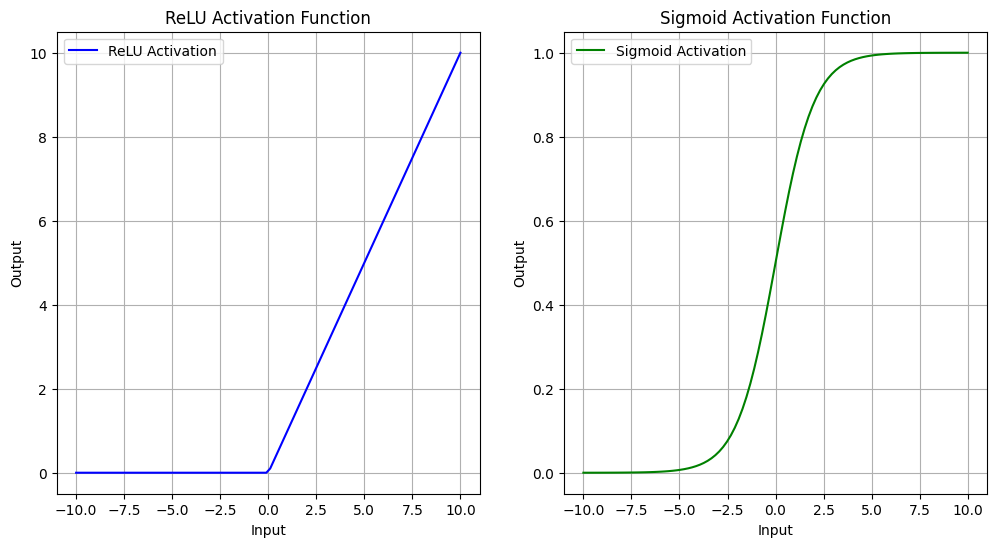

In [74]:
# TODO Test your activation functions, is the returning values what you expect?
x = np.linspace(-10, 10, 100)
y_relu = activate(x, selected_function="relu")
y_sigmoid = activate(x, selected_function="sigmoid")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, y_relu, label='ReLU Activation', color='blue')
plt.title('ReLU Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, y_sigmoid, label='Sigmoid Activation', color='green')
plt.title('Sigmoid Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()
plt.show()

### 2) Activation function derivatives

Neural networks need both the activation function and its derivative. Finish the code below.

In [75]:
def d_activate(activations, selected_function = "none"):
    if selected_function == "none":
        dy = np.ones_like(activations)
    elif selected_function == "relu":
        dy = np.where(activations > 0, 1, 0)
    elif selected_function == "sigmoid":
        dy = activate(activations, selected_function="sigmoid") * (1 - activate(activations, selected_function="sigmoid"))
    return dy

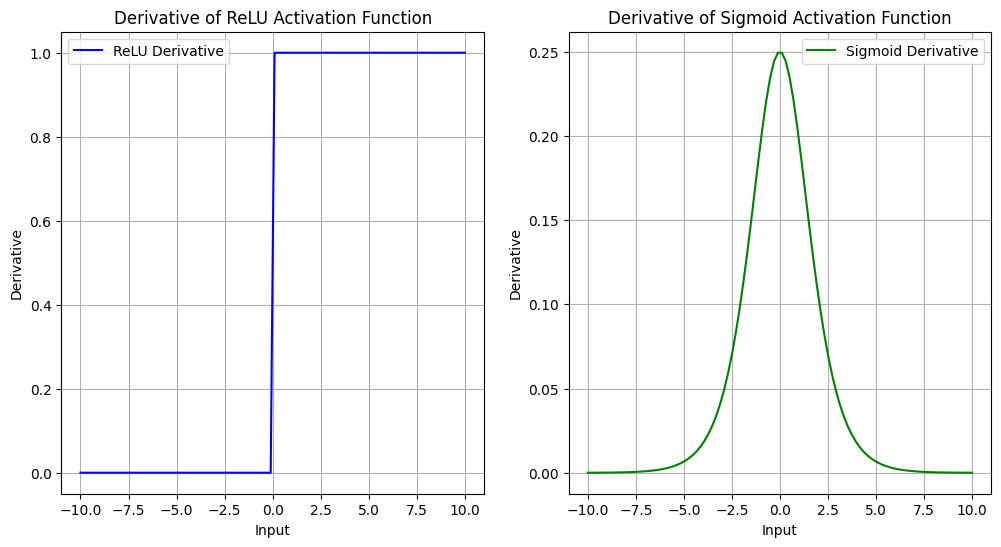

In [76]:
# TODO Test your activation function derivatives, is the returning values what you expect?
x = np.linspace(-10, 10, 100)
dy_relu = d_activate(x, selected_function="relu")
dy_sigmoid = d_activate(x, selected_function="sigmoid")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, dy_relu, label='ReLU Derivative', color='blue')
plt.title('Derivative of ReLU Activation Function')
plt.xlabel('Input')
plt.ylabel('Derivative')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, dy_sigmoid, label='Sigmoid Derivative', color='green')
plt.title('Derivative of Sigmoid Activation Function')
plt.xlabel('Input')
plt.ylabel('Derivative')
plt.grid()
plt.legend()
plt.show()

### 3) Loss functions

To penalize the network when it predicts incorrect, we need to meassure how "bad" the prediction is. This is done with loss-functions.

Similar as with the activation functions, the loss function needs its derivative as well.

Finish the MSE_loss (Mean Squared Error loss), as well as adding one additional loss function.

In [77]:
# This is the loss for a set of predictions y_hat compared to a set of real valyes y
def MSE_loss(y_hat, y):
    loss = np.mean((y_hat - y) ** 2)
    return loss


# TODO: Choose another loss function and implement it
def other_loss(y_hat, y):
    loss = np.mean(np.abs(y_hat - y))  # L1 loss (Mean Absolute Error)
    return loss

The derivatives of the loss is with respect to the predicted value **y_hat**.

In [78]:
def d_MSE_loss(y_hat, y):
    dy = 2 * (y_hat - y) / y.size
    return dy

# TODO: Choose another loss function and implement it
def d_other_loss(y_hat, y):
    dy = np.sign(y_hat - y) / y.size  # Derivative of L1 loss (Mean Absolute Error)
    return dy

### 4) Forward propagation

The first "fundamental" function for neural networks is to be able to propagate the data forward through the neural network. We will implement this function here.

In [79]:
def propagate_forward(weights, activations, bias, activation_function="none"):
    dot_product = np.dot(activations, weights) + bias
    new_activations = activate(dot_product, activation_function)
    return new_activations

### 5) Back-propagation

To be able to train a neural network, we need to be able to propagate the loss backwards and update the weights. We will implement this function here.

In [80]:
# Calculates the backward gradients that are passed throught the layer in the backward pass.
# Returns both the derivative of the loss in respect to the weights and the input signal (activations).

def propagate_backward(weights, activations, dl_dz, bias, activation_function="none"):
    # NOTE: dl_dz is the derivative of the loss based on the previous layers activations/outputs
    dot_product = np.dot(activations, weights) + bias
    d_loss = d_activate(dot_product, activation_function) * dl_dz
    d_weights = np.dot(activations.T, d_loss)
    d_bias = np.sum(d_loss, axis=0, keepdims=True)
    d_activations = np.dot(d_loss, weights.T)
    
    return d_weights, d_bias, d_activations

## Neural network implementation

### 6) Fixing the neural network

Below is a class implementation of a MLP neural network. This implementation is still lacking several areas that are needed for the network to be robust and function well. Your task is to improve and fix it with the following:

1. Add a bias to the activation functions, and make sure the bias is also updated during training. 
2. Add a function that trains the network using minibatches (such that the neural network trains on a few samples at a time). 
3. Make use of an validation set in the training function. The model should stop training when the loss starts to increase for the validatin set. This feature should be able to be turned on and off to test the difference.


In [ ]:
class NeuralNet(object):
    
    # Setup all parameters and activation functions.
    # This function runs directly when a new instance of this class is created.
    def __init__ (self, input_dim, output_dim, neurons = []):

        # NOTE: The "neurons" parameter is given as a list.
        # E.g., [4, 8, 4] means 4 neurons in layer 1, 8 neurons in layer 2 etc...

        # TODO: Add support for bias for each neuron in the code below.
        
        self.weights = [np.random.normal(0,2,(n,m)) for n,m in
                   zip([input_dim] + neurons, neurons + [output_dim])]
        self.biases = [np.zeros((1,m)) for m in neurons + [output_dim]]
        
        self.activation_functions = ["relu"] * len(neurons) + ["none"]
    
    
    # Predict the input throught the network and calculate the output.
    def forward(self, x):

        # TODO: Add support for a bias for each neuron in the code below.
        for layer_weights, layer_bias, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            x = propagate_forward(layer_weights, x, layer_activation_function, bias=layer_bias)
            
        return x
    
    
    # Adjust the weights in the network to better fit the desired output (y), given the input (x).
    # The weight updates are happening "in-place", thus we are only returning the loss from this function.
    # Note that this function can handle a variable size of the input (x), both full datasets or smaller parts of the dataset.
    def adjust_weights(self, x, y, learning_rate=1e-4):
        activation = x
        activation_history = [] # NOTE: We need the previous (or intermediate) activations to make use of the "chain rule" (see lecture notes).
        
        for layer_weights, layer_bias, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            activation_history.append(activation)
            activation = propagate_forward(layer_weights, activation, layer_bias, layer_activation_function)
           
        # NOTE: The "activation" variable is changing as we go forward in the neural network.
        loss = MSE_loss(activation,y)
        d_activations = d_MSE_loss(activation,y) # NOTE: The final output can be "seen as" the final activations, thus the name.
        
        for layer_weights, layer_bias, layer_activation_function, previous_activations in reversed(list(zip(self.weights, self.biases, self.activation_functions, activation_history))):
            d_weights, d_bias, d_activations = propagate_backward(layer_weights, previous_activations, d_activations, layer_bias, layer_activation_function)

            # NOTE: Here is where the weight update is happening.
            layer_weights -= learning_rate * d_weights
            layer_bias -= learning_rate * d_bias
                        
        return loss
    
    
    # A function for the training of the network.
    def train_net(self, x, y, batch_size=32, epochs=100, learning_rate=1e-4, use_validation_data=False):
        loss_history = []
        
        num_samples = x.shape[0]
        
        if use_validation_data:
            split_index = int(0.8 * num_samples)
            x_train, x_val = x[:split_index], x[split_index:]
            y_train, y_val = y[:split_index], y[split_index:]
            x_to_train = x_train
            y_to_train = y_train
            num_samples_train = x_train.shape[0]
        else:
            x_to_train = x
            y_to_train = y
            num_samples_train = num_samples

        for epoch in range(epochs):
            indices = np.random.permutation(num_samples_train)
            x_shuffled = x_to_train[indices]
            y_shuffled = y_to_train[indices]
            
            epoch_loss = 0
            num_batches = 0
            
            for i in range(0, num_samples_train, batch_size):
                x_batch = x_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # adjust_weights returns the loss for this batch
                current_loss = self.adjust_weights(x_batch, y_batch, learning_rate)
                epoch_loss += current_loss
                num_batches += 1
            
            avg_loss = epoch_loss / num_batches
            loss_history.append(avg_loss)
            
            if epoch % 10 == 0: # Print every 10 epochs to reduce clutter
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # Validation and early stopping
        if use_validation_data:
            best_loss = float('inf')
            patience = 5 
            patience_counter = 0

            for epoch in range(epochs):
                loss = self.adjust_weights(x_train, y_train, learning_rate)
                val_loss = MSE_loss(self.forward(x_val), y_val)

                print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")

                if val_loss < best_loss:
                    best_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print("Early stopping due to no improvement in validation loss.")
                    break

        # NOTE: Make use of previously implemented functions here.
        return loss_history
    

## Train Neural Networks

### 7) Simple test

In this a very simple test for you to use and toy around with before using the datasets.

Make sure to test both the **adjust_weights** function and the **train_net** function. What is the difference between the two?

Also, be sure to **plot the loss for each epoch** to see how the network training is progressing!

Epoch 1/100, Loss: 574.0016
Epoch 11/100, Loss: 66.9985
Epoch 21/100, Loss: 44.7526
Epoch 31/100, Loss: 33.0439
Epoch 41/100, Loss: 25.7931
Epoch 51/100, Loss: 20.5656
Epoch 61/100, Loss: 16.7635
Epoch 71/100, Loss: 13.6040
Epoch 81/100, Loss: 11.4410
Epoch 91/100, Loss: 9.6021


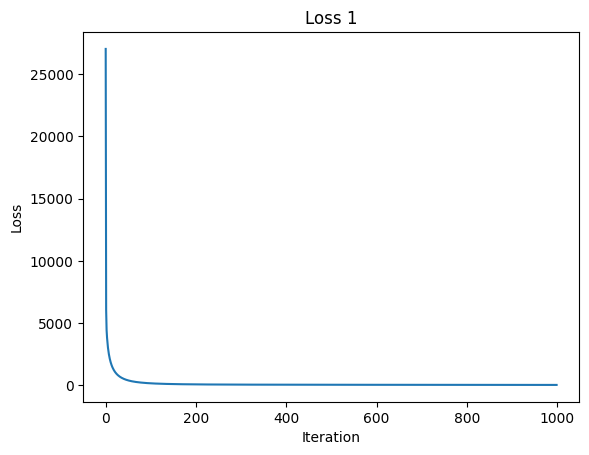

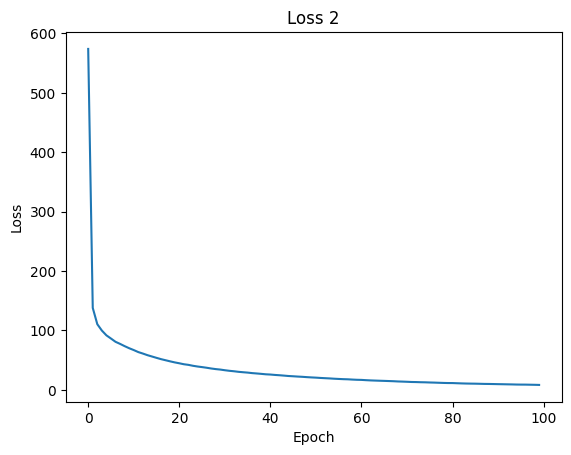

In [91]:
# TODO: You can change most things in this cell if you want to, we encurage it!

n = 5000
d = 10

k = np.random.randint(0,10,(d,1))
x = np.random.normal(0,1,(n,d))
y = np.dot(x,k) + 0.1 + np.random.normal(0,0.01,(n,1))

                        
nn1 = NeuralNet(d, 1, [18, 12])
nn2 = NeuralNet(d, 1, [18, 12])

loss_1 = [nn1.adjust_weights(x, y) for _ in range(1000)] 

loss_2 = nn2.train_net(x, y, batch_size=32, epochs=100, learning_rate=1e-4, use_validation_data=False)

# The difference between using adjust weight and train_net is optimization strategy:
# Batch Gradiant Descent (adjust_weights) vs Mini-Batch Gradient Descent (train_net).
# BGD processes the entire dataset for each weight update. Very stable but computationally expensive
# MGD processes smaller batches which updates much faster and more often. It is more noisy but can escape local minima and often converges faster.

plt.plot(loss_1)
plt.title("Loss 1")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.plot(loss_2)
plt.title("Loss 2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Real test and preprocessing

When using real data and neural networks, it is very important to scale the data between smaller values, usually between 0 and 1. This is because neural networks struggle with larger values as input compared to smaller values. 

To test this, we will use our first dataset and test with and without scaling.

Similar as with assignment 2, we will use the scikit-learn library for this preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html

### 8) Dataset 1: Wine - with and without scaling

Read about the Wine dataset: https://archive.ics.uci.edu/dataset/109/wine

Train two neural network, one with scaling and one without. Are we able to see any difference in training results or loss over time?

**Note:** Do not train for to many epochs (more than maybe 50-100). The network might "learn" anyway in the end, but you should still be able to see a difference when training.

===== Run 1 =====
Unscaled Training:
Epoch 1/100, Loss: 142412646716332773933036840419328.0000
Epoch 11/100, Loss: 2646930257803617132085248.0000
Epoch 21/100, Loss: 2629342161938018683846656.0000
Epoch 31/100, Loss: 2611870933947988953792512.0000
Epoch 41/100, Loss: 2594515797279961849528320.0000
Epoch 51/100, Loss: 2577275980540157083254784.0000
Epoch 61/100, Loss: 2560150717460750861860864.0000
Epoch 71/100, Loss: 2543139246865148391981056.0000
Epoch 81/100, Loss: 2526240812634888472625152.0000
Epoch 91/100, Loss: 2509454663675631649161216.0000
Scaled Training
Epoch 1/100, Loss: 13835.9450
Epoch 11/100, Loss: 739.6683
Epoch 21/100, Loss: 412.0565
Epoch 31/100, Loss: 276.8369
Epoch 41/100, Loss: 207.0813
Epoch 51/100, Loss: 150.9870
Epoch 61/100, Loss: 123.8123
Epoch 71/100, Loss: 106.1460
Epoch 81/100, Loss: 99.2332
Epoch 91/100, Loss: 78.3010
===== Run 2 =====
Unscaled Training:
Epoch 1/100, Loss: 93061440925121144155311408743756977125205797768446129068952256512.0000
Epoch 11/100, 

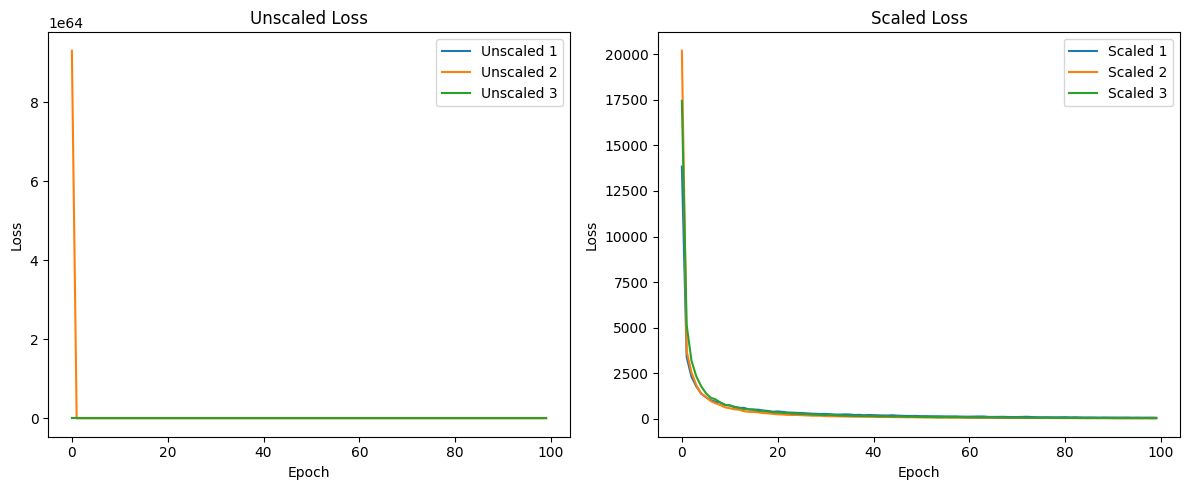

In [108]:
from sklearn import preprocessing # For one-hot-encoding and scaling if needed
from sklearn.model_selection import train_test_split

# Load Data
data_wine = pd.read_csv("wine.csv", header=1).to_numpy()

# Data and Label split
X_unscaled = data_wine[:, :-1]
y_raw = data_wine[:, -1].astype(int)

# One-hot encoding of the labels
# Labels [1, 2, 3] -> [0, 1, 2]# TODO: Plot the results with matplotlib (plt)
target_encoder = preprocessing.LabelEncoder()
y_raw = target_encoder.fit_transform(y_raw)

num_classes = len(np.unique(y_raw))
y_onehot = np.eye(num_classes)[y_raw]

# Train-test split and scaling
x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X_unscaled, y_onehot, test_size=0.2, random_state=42)
scaler = preprocessing.StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_unscaled)
x_test_scaled = scaler.transform(x_test_unscaled)

# Network setup
input_dim = x_train_unscaled.shape[1]
losses_unscaled = []
losses_scaled = []
accuracies_unscaled = []
accuracies_scaled = []

# Training
for i in range(3):
    nn_wine_unscaled = NeuralNet(input_dim, num_classes, [18, 12])
    nn_wine_scaled = NeuralNet(input_dim, num_classes, [18, 12])
    
    print(f"===== Run {i+1} =====")
    # Train Unscaled
    print("Unscaled Training:")
    loss_u = nn_wine_unscaled.train_net(x_train_unscaled, y_train, batch_size=32, epochs=100, learning_rate=1e-4)
    losses_unscaled.append(loss_u)
    print("Scaled Training")
    # Train Scaled
    loss_s = nn_wine_scaled.train_net(x_train_scaled, y_train, batch_size=32, epochs=100, learning_rate=1e-4)
    losses_scaled.append(loss_s)

# Plot the loss
plt.figure(figsize=(12, 5))
# Plot 1: Unscaled
plt.subplot(1, 2, 1) # Row 1, Col 2, Index 1 (Left)
for i, loss in enumerate(losses_unscaled):
    plt.plot(loss, label=f"Unscaled {i+1}")
plt.title("Unscaled Loss") # Fixed typo "Unsacled"
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot 2: Scaled
plt.subplot(1, 2, 2) # Row 1, Col 2, Index 2 (Right) <--- CHANGE THIS
for i, loss in enumerate(losses_scaled):
    plt.plot(loss, label=f"Scaled {i+1}")
plt.title("Scaled Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Real data and hyper-parameter tuning

Now we are going to use real data, preprocess it, and do hyper-parameter tuning.

Choose two hyper-parameters to tune to try and achive an even better result. **Each chosen parameter needs to have at least 3 different values**. For example, if we were to choose "epochs" then we could test 10, 50, and 100 (optionally more). 

To better see what each hyper-parameter does to the models performance, we recommend doing a *grid-search* on the two chosen parameters. A grid-search tests how the two parameters interact with eachother. There might be a setting in parameter 1 that in combination with a setting in parameter 2 makes the model perform significantly better, compared to the other combinations. A grid-search test all these combinations.

**IMPORTANT NOTE:** Changing the **number of epochs** can be part of the tuning, but it **does not count** towards the two hyper parameters you choose.

### 9) Dataset 2: Mushroom

Read about the Mushroom dataset: https://archive.ics.uci.edu/dataset/73/mushroom

In [84]:
from sklearn import preprocessing # For one-hot-encoding and scaling if needed
from sklearn.model_selection import train_test_split

data_mushroom = pd.read_csv("mushroom.csv").to_numpy()

# TODO: Preprocess the data.
# NOTE: You can choose how to handle data with missing values. Either remove or "fix" the missing data.

# TODO: Split the data into train and test

# TODO: Train a neural network on the data

# TODO: Visualize the loss for each epoch

# TODO: Visulaize the test accuracy for each epoch

When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: 
* Parameter 2:

* Neural network sizes: 

In [85]:
# TODO: Hyper-parameter tuning

# TODO: Visualize the loss after hyper-parameter tuning for each epoch

# TODO: Visulaize the test accuracy after hyper-parameter tuning for each epoch

### 10) Dataset 3: Adult

Read about the Adult dataset: https://archive.ics.uci.edu/dataset/2/adult

**IMPORTANT NOTE:** This dataset is much larger than the previous two (48843 instances). If your code runs slow on your own computer, either run this on the compute-server, or you may exclude parts of this dataset. But you must keep a minimum of 10000 datapoints.

In [86]:
from sklearn import preprocessing # For one-hot-encoding and scaling if needed
from sklearn.model_selection import train_test_split

dataset_3 = pd.read(...) # TODO: Read the data.

# TODO: Preprocess the data.
# NOTE: You can choose how to handle data with missing values. Either remove or "fix" the missing data.

# TODO: Split the data into train and test

# TODO: Train a neural network on the data

# TODO: Visualize the loss for each epoch

# TODO: Visulaize the test accuracy for each epoch

AttributeError: module 'pandas' has no attribute 'read'

When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: 
* Parameter 2:

* Neural network sizes: 

In [ ]:
# TODO: Hyper-parameter tuning

# TODO: Visualize the loss after hyper-parameter tuning for each epoch

# TODO: Visulaize the test accuracy after hyper-parameter tuning for each epoch

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why would we want to use different activation functions?

2) Why would we want to use different loss functions?

3) Why are neural networks sensitive to large input values?

4) What is the role of the bias? 

5) What is the purpose of hyper-parameter tuning?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!